
# 1.IMPORTS & SETUP


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Sklearn Modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

# Setup Plot Style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Libraries Imported Successfully")

✅ Libraries Imported Successfully


# 2.DATA LOADING & DESCRIPTION

In [6]:
# 1. Load Data
try:
    df = pd.read_csv('/content/AmesHousing.csv')
    print("✅ Dataset Loaded Successfully")
except FileNotFoundError:
    print("❌ Error: 'AmesHousing.csv' not found. Please upload it.")

# 2. Clean Column Names (Remove spaces)
df.columns = df.columns.str.replace(' ', '')

# 3. Dataset Overview
print(f"\nDataset Shape: {df.shape[0]} Rows, {df.shape[1]} Columns")
print("-" * 40)
print("FEATURE DESCRIPTIONS (Key Features):")
feature_table = pd.DataFrame({
    'Feature': ['SalePrice', 'OverallQual', 'GrLivArea', 'YearBuilt', 'FullBath', 'BedroomAbvGr'],
    'Type': ['Target (Numeric)', 'Ordinal (1-10)', 'Continuous (SqFt)', 'Discrete (Year)', 'Count', 'Count'],
    'Description': ['Sale price ($)', 'Material & Finish Quality', 'Above ground living area',
                    'Original Construction Year', 'Number of Full Bathrooms', 'Number of Bedrooms']
})
print(feature_table)
print("-" * 40)

# 4. Missing Value Check
missing = df.isnull().sum()
print("\nTop Missing Values:")
print(missing[missing > 0].sort_values(ascending=False).head(5))

✅ Dataset Loaded Successfully

Dataset Shape: 2930 Rows, 82 Columns
----------------------------------------
FEATURE DESCRIPTIONS (Key Features):
        Feature               Type                 Description
0     SalePrice   Target (Numeric)              Sale price ($)
1   OverallQual     Ordinal (1-10)   Material & Finish Quality
2     GrLivArea  Continuous (SqFt)    Above ground living area
3     YearBuilt    Discrete (Year)  Original Construction Year
4      FullBath              Count    Number of Full Bathrooms
5  BedroomAbvGr              Count          Number of Bedrooms
----------------------------------------

Top Missing Values:
PoolQC         2917
MiscFeature    2824
Alley          2732
Fence          2358
MasVnrType     1775
dtype: int64


# 3. DATA PREPROCESSING

In [7]:
print("\n--- PREPROCESSING STEPS ---")

# 1. Feature Selection
selected_features = ['OverallQual', 'YearBuilt', 'GrLivArea', 'FullBath', 'BedroomAbvGr']
X = df[selected_features]
y_reg = df['SalePrice']

# 2. Handling Missing Values (Mean Imputation)
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
print("✅ Missing values imputed with Mean.")

# 3. Feature Engineering (Classification Target)
# Create Neighborhood Tier: 1 (Premium) if Price > Median, else 0 (Standard)
median_price = y_reg.median()
y_class = (y_reg > median_price).astype(int)
print(f"✅ Target Engineered: 'Neighborhood_Tier' (Split at Median Price: ${median_price:,.0f})")
print(f"Class Balance:\n{y_class.value_counts(normalize=True)}")

# 4. Train-Test Split (80% Train, 20% Test)
X_train, X_test, y_reg_train, y_reg_test, y_class_train, y_class_test = train_test_split(
    X, y_reg, y_class, test_size=0.2, random_state=42
)

# 5. Scaling (Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("✅ Data Scaled (Mean=0, Variance=1).")


--- PREPROCESSING STEPS ---
✅ Missing values imputed with Mean.
✅ Target Engineered: 'Neighborhood_Tier' (Split at Median Price: $160,000)
Class Balance:
SalePrice
0    0.500683
1    0.499317
Name: proportion, dtype: float64
✅ Data Scaled (Mean=0, Variance=1).


# 4.EXPLORATORY DATA ANALYSIS (EDA)


--- GENERATING EDA PLOTS ---


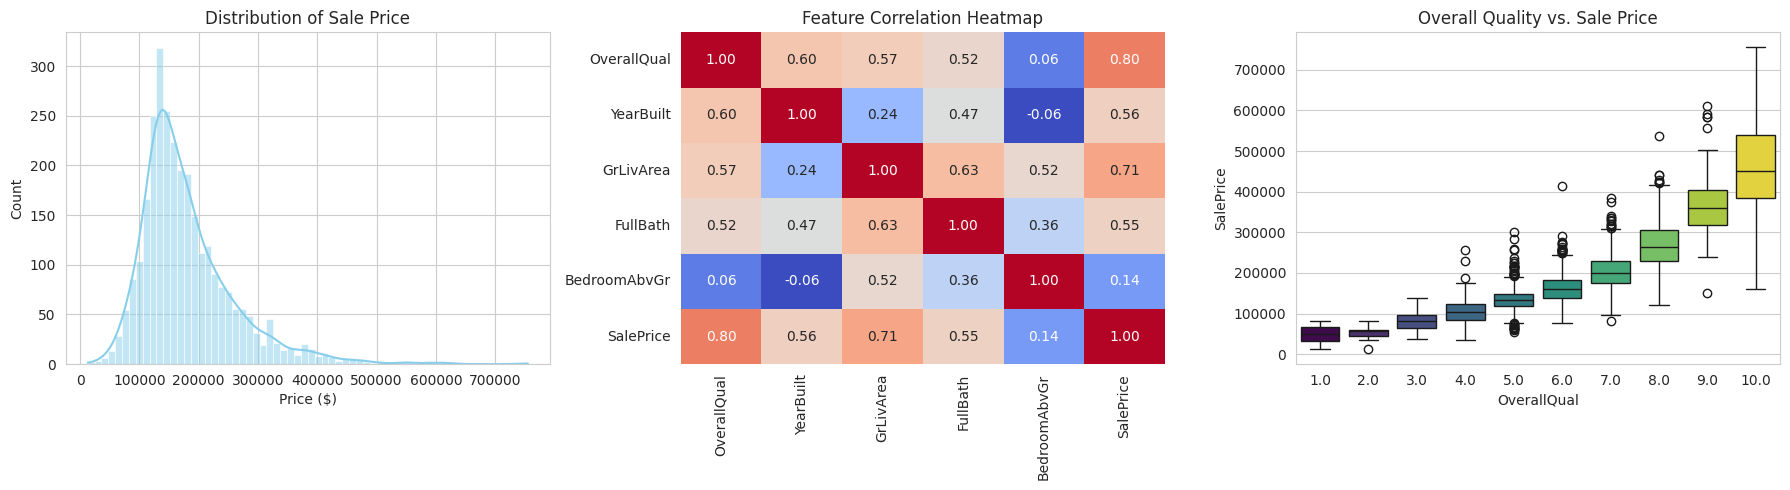

In [8]:
print("\n--- GENERATING EDA PLOTS ---")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Distribution of Price
sns.histplot(y_reg, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Distribution of Sale Price')
axes[0].set_xlabel('Price ($)')

# Plot 2: Correlation Heatmap
# Combine X and y for correlation check
corr_df = X.copy()
corr_df['SalePrice'] = y_reg
sns.heatmap(corr_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=False, ax=axes[1])
axes[1].set_title('Feature Correlation Heatmap')

# Plot 3: Boxplot (Quality vs Price) -- FIXED WARNING HERE
sns.boxplot(x=X['OverallQual'], y=y_reg, hue=X['OverallQual'], palette='viridis', legend=False, ax=axes[2])
axes[2].set_title('Overall Quality vs. Sale Price')

plt.tight_layout()
plt.show()

# 5. MODEL TRAINING & COMPARISON

In [9]:
print("\n--- TRAINING & COMPARING ALGORITHMS ---")

# A. REGRESSION MODELS
reg_models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

reg_results = []
for name, model in reg_models.items():
    model.fit(X_train_scaled, y_reg_train)
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_reg_test, y_pred))
    r2 = r2_score(y_reg_test, y_pred)
    reg_results.append({"Algorithm": name, "RMSE": rmse, "R2": r2})

# B. CLASSIFICATION MODELS
class_models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

class_results = []
roc_data = {} # Store for plotting

for name, model in class_models.items():
    model.fit(X_train_scaled, y_class_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    acc = accuracy_score(y_class_test, y_pred)
    prec = precision_score(y_class_test, y_pred)
    rec = recall_score(y_class_test, y_pred)
    f1 = f1_score(y_class_test, y_pred)

    class_results.append({"Algorithm": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1})
    roc_data[name] = (y_class_test, y_proba)

# Display Results
print("\n>>> Regression Comparison:")
reg_df = pd.DataFrame(reg_results).sort_values(by='RMSE')
print(reg_df)

print("\n>>> Classification Comparison:")
class_df = pd.DataFrame(class_results).sort_values(by='Accuracy', ascending=False)
print(class_df)


--- TRAINING & COMPARING ALGORITHMS ---

>>> Regression Comparison:
           Algorithm          RMSE        R2
2      Random Forest  34994.859990  0.847255
0  Linear Regression  43072.566387  0.768602
1      Decision Tree  46466.383549  0.730700

>>> Classification Comparison:
             Algorithm  Accuracy  Precision    Recall        F1
2        Random Forest  0.933447   0.943333  0.927869  0.935537
4                  KNN  0.931741   0.937294  0.931148  0.934211
3                  SVM  0.921502   0.911111  0.940984  0.925806
0  Logistic Regression  0.909556   0.906452  0.921311  0.913821
1        Decision Tree  0.894198   0.885714  0.914754  0.900000
5          Naive Bayes  0.883959   0.873817  0.908197  0.890675


# 6. EVALUATION VISUALIZATIONS


--- MODEL PERFORMANCE GRAPHS ---


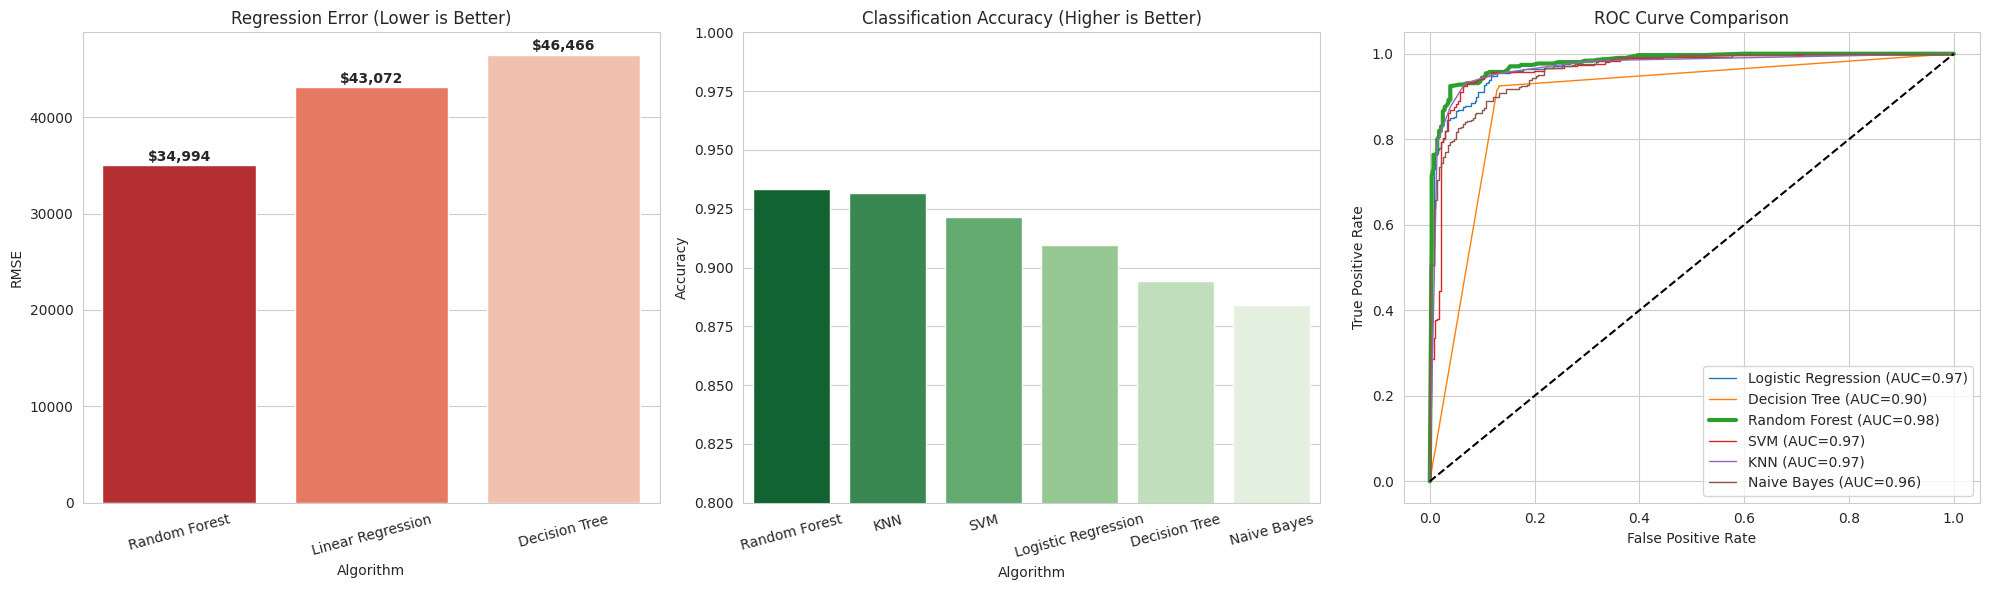


Visualizing Confusion Matrix for Champion Model: Random Forest


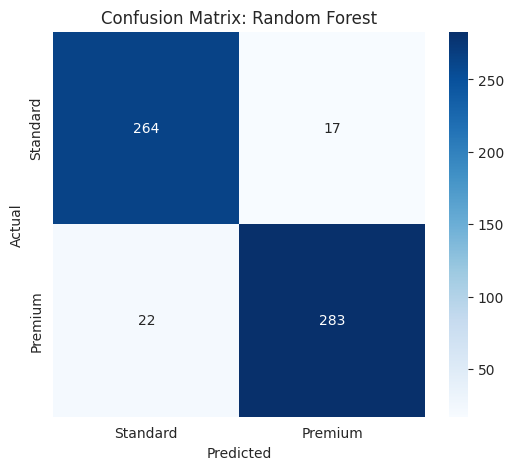

In [10]:
print("\n--- MODEL PERFORMANCE GRAPHS ---")
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Graph 1: Regression RMSE Comparison -- FIXED WARNING HERE
sns.barplot(x='Algorithm', y='RMSE', data=reg_df, hue='Algorithm', palette='Reds_r', legend=False, ax=axes[0])
axes[0].set_title('Regression Error (Lower is Better)')
axes[0].tick_params(axis='x', rotation=15)
for i, v in enumerate(reg_df['RMSE']):
    axes[0].text(i, v + 500, f"${int(v):,}", ha='center', fontweight='bold')

# Graph 2: Classification Accuracy Comparison -- FIXED WARNING HERE
sns.barplot(x='Algorithm', y='Accuracy', data=class_df, hue='Algorithm', palette='Greens_r', legend=False, ax=axes[1])
axes[1].set_title('Classification Accuracy (Higher is Better)')
axes[1].set_ylim(0.8, 1.0)
axes[1].tick_params(axis='x', rotation=15)

# Graph 3: ROC Curves
for name, (y_test_roc, y_proba_roc) in roc_data.items():
    fpr, tpr, _ = roc_curve(y_test_roc, y_proba_roc)
    roc_auc = auc(fpr, tpr)
    # Highlight Random Forest
    lw = 3 if 'Random Forest' in name else 1
    axes[2].plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.2f})', lw=lw)

axes[2].plot([0, 1], [0, 1], 'k--')
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('ROC Curve Comparison')
axes[2].legend(loc='lower right')

plt.tight_layout()
plt.show()

# Extra: Confusion Matrix for Best Model
best_model_name = class_df.iloc[0]['Algorithm']
print(f"\nVisualizing Confusion Matrix for Champion Model: {best_model_name}")
best_clf = class_models[best_model_name]
y_pred_best = best_clf.predict(X_test_scaled)
cm = confusion_matrix(y_class_test, y_pred_best)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Standard', 'Premium'], yticklabels=['Standard', 'Premium'])
plt.title(f'Confusion Matrix: {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 7. SAVE BEST MODELS FOR DEPLOYMENT

In [13]:
print("\n--- SAVING CHAMPION MODELS FOR STREAMLIT ---")

# We choose Random Forest as the Champion for both tasks
# (Ensure X_train_scaled and y_train variables exist from previous cells)
final_reg_model = RandomForestRegressor(n_estimators=100, random_state=42)
final_reg_model.fit(X_train_scaled, y_reg_train)

final_class_model = RandomForestClassifier(n_estimators=100, random_state=42)
final_class_model.fit(X_train_scaled, y_class_train)

# Save to files locally in Colab
joblib.dump(final_reg_model, 'price_model.pkl')
joblib.dump(final_class_model, 'class_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("✅ 'price_model.pkl' Saved!")
print("✅ 'class_model.pkl' Saved!")
print("✅ 'scaler.pkl' Saved!")
print("🚀 Ready for Streamlit Deployment!")

# --- GOOGLE COLAB DOWNLOAD SECTION ---
# This block is now uncommented and indented correctly
from google.colab import files
files.download('price_model.pkl')
files.download('class_model.pkl')
files.download('scaler.pkl')


--- SAVING CHAMPION MODELS FOR STREAMLIT ---
✅ 'price_model.pkl' Saved!
✅ 'class_model.pkl' Saved!
✅ 'scaler.pkl' Saved!
🚀 Ready for Streamlit Deployment!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>